<a href="https://colab.research.google.com/github/ninja-marduk/ml_precipitation_prediction/blob/feature%2Fhybrid-models/models/hybrid_models_enconders_layering_w3_ST-HybridWaveStack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounted at /content/drive
▶️ Base path: /content/drive/MyDrive/ml_precipitation_prediction
Metrics_w3_ref2025-02


Loading ITables v2.4.0 from the internet... (need help?)


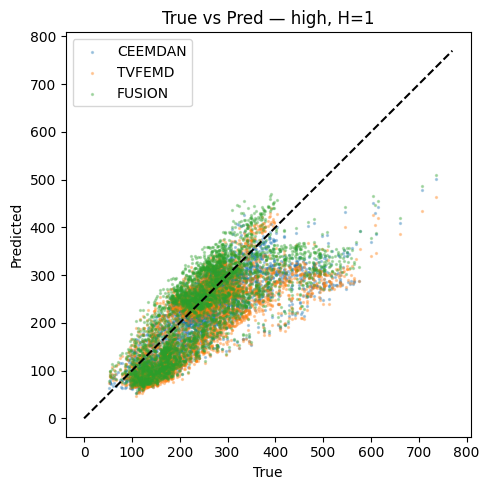

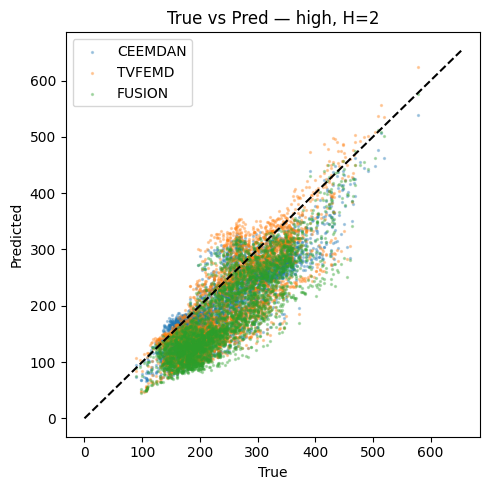

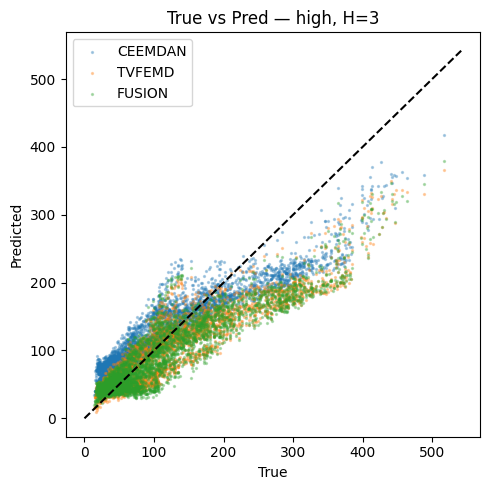

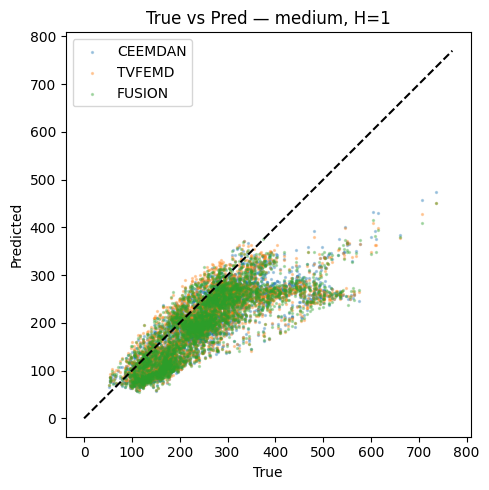

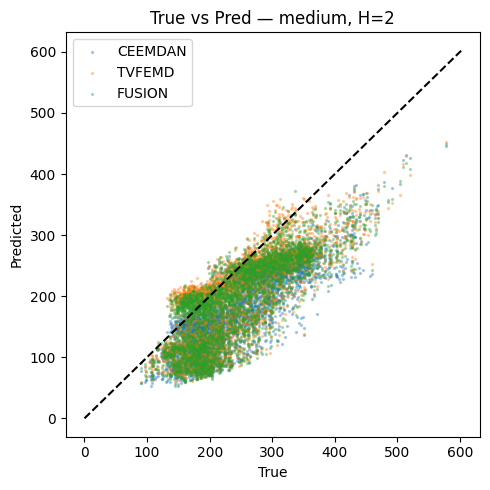

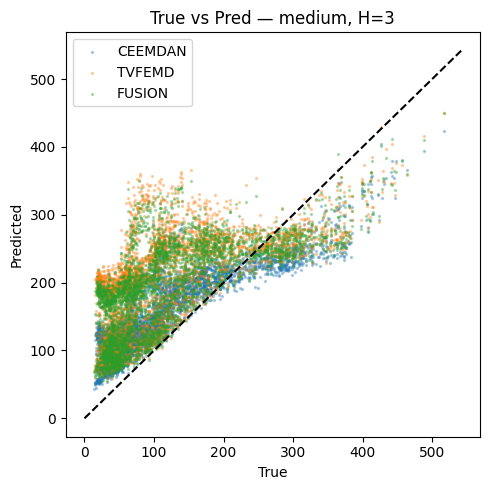

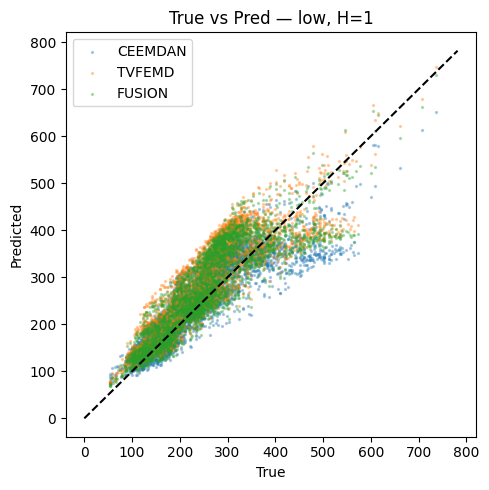

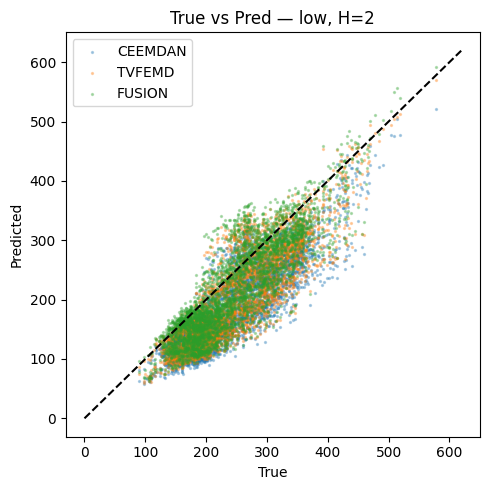

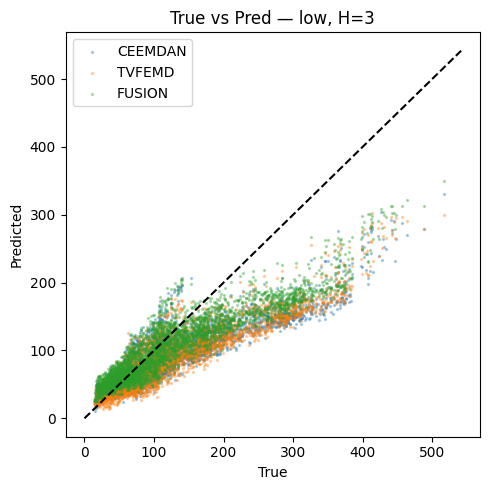

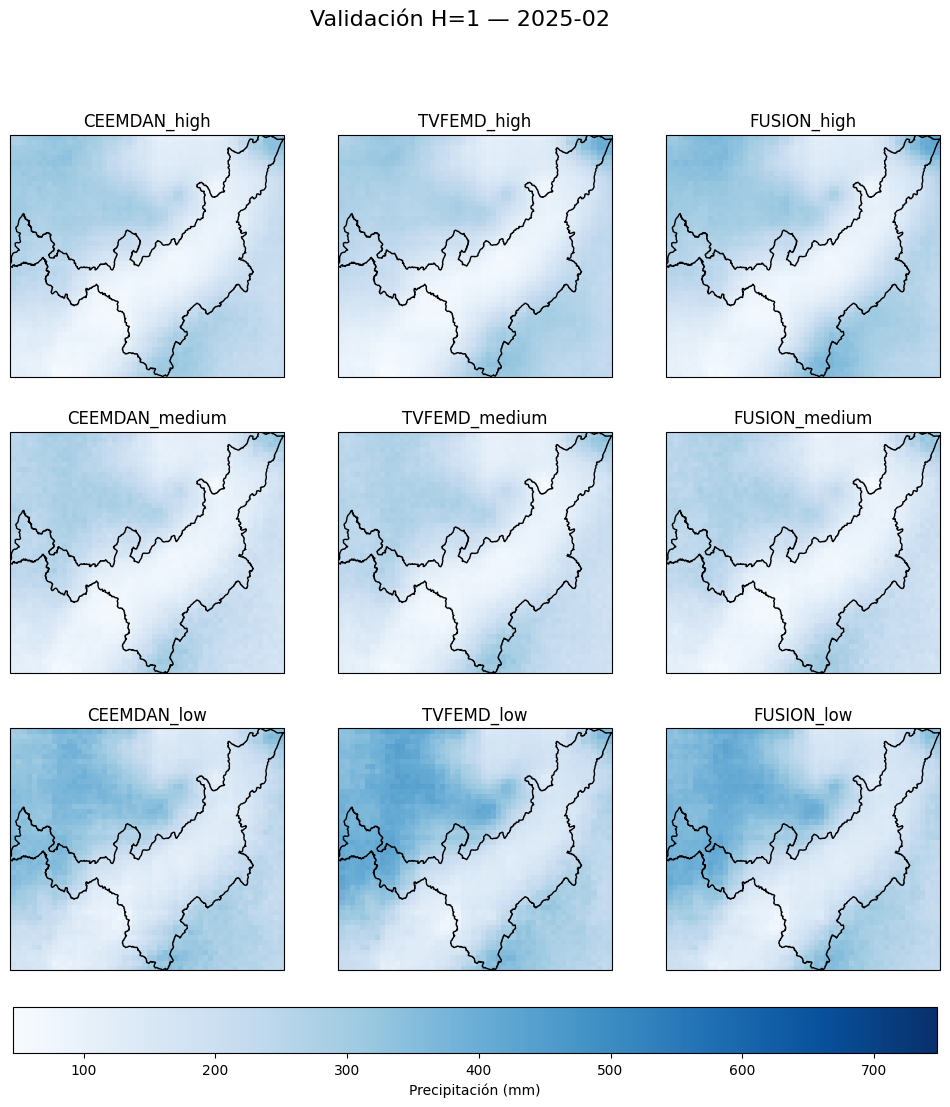

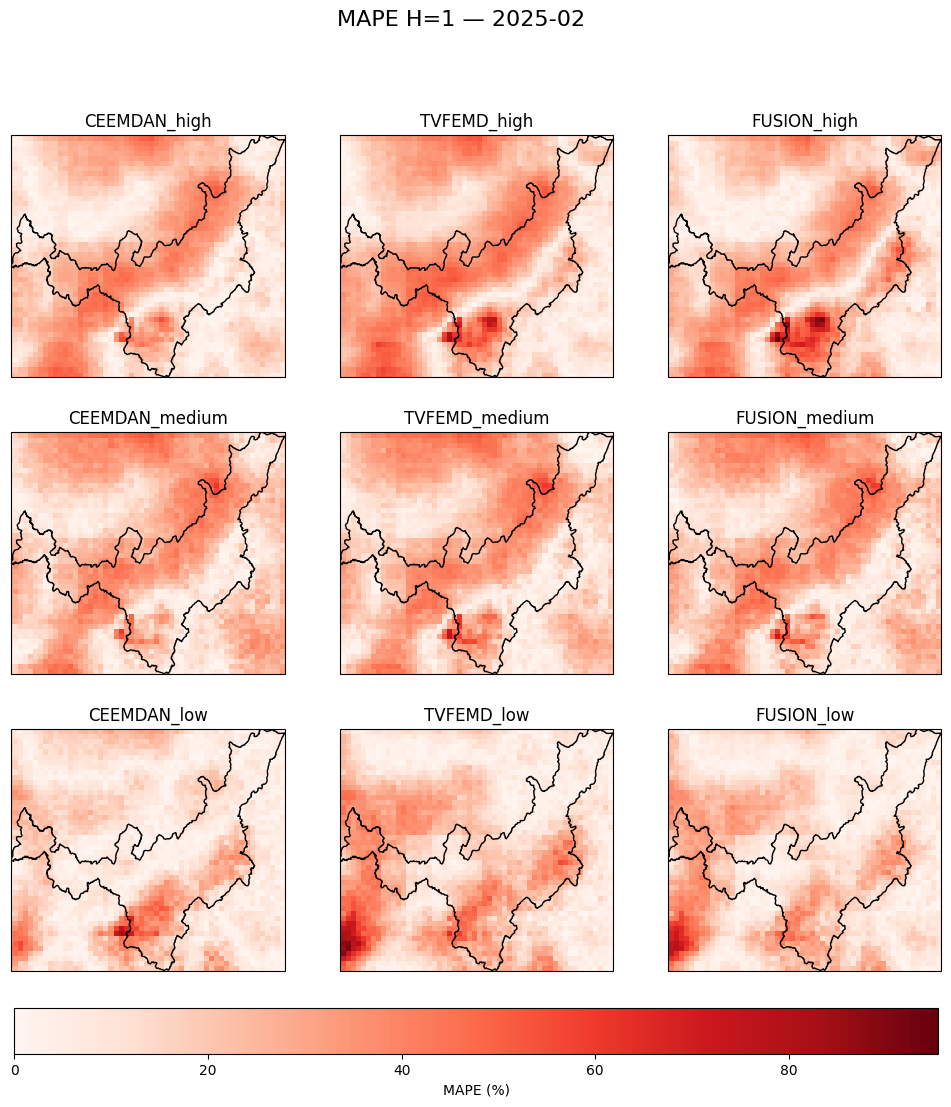

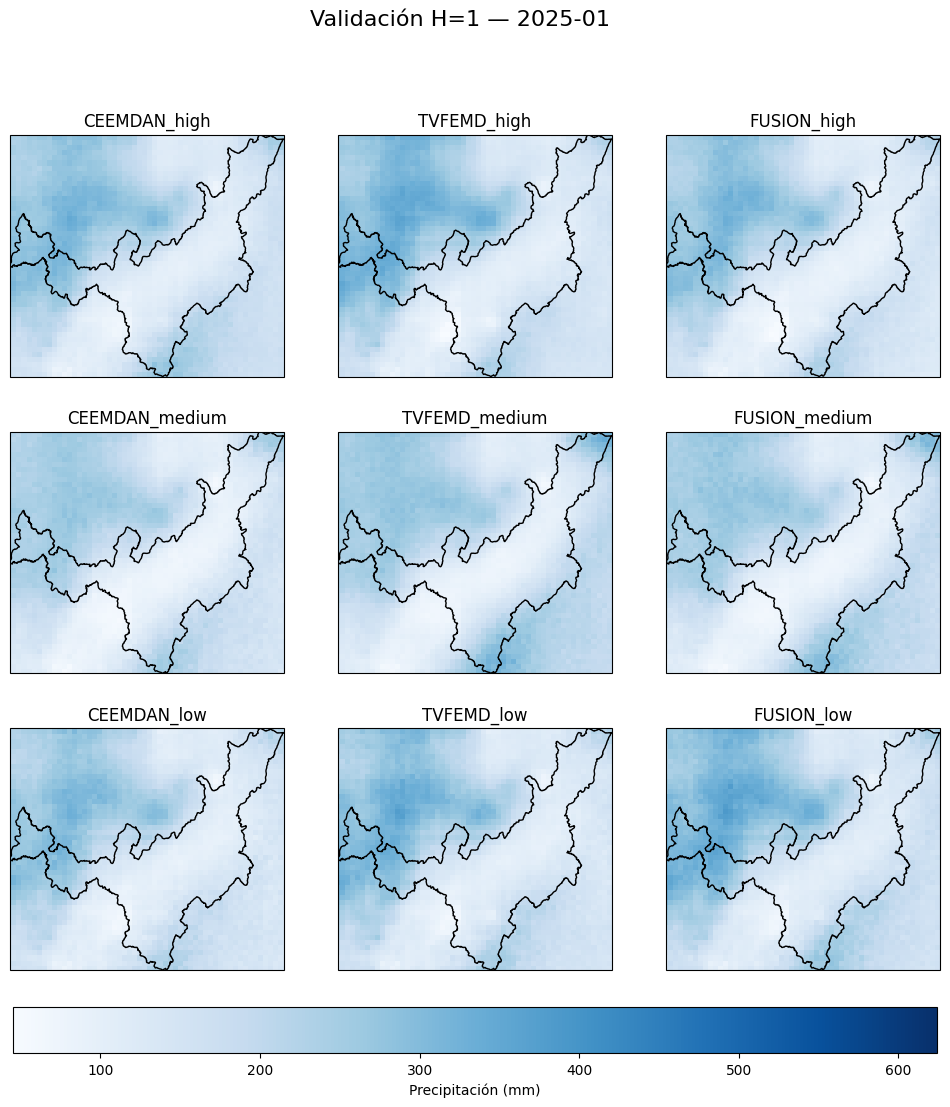

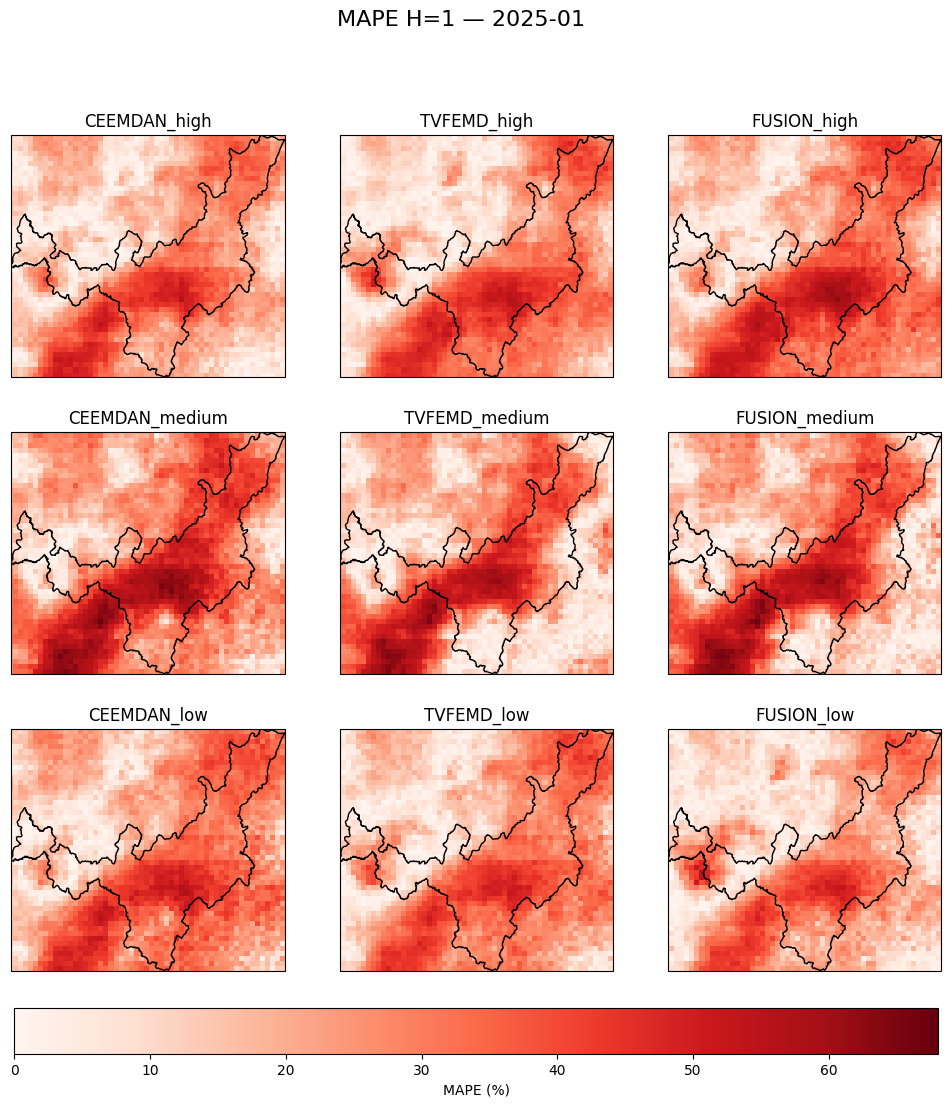

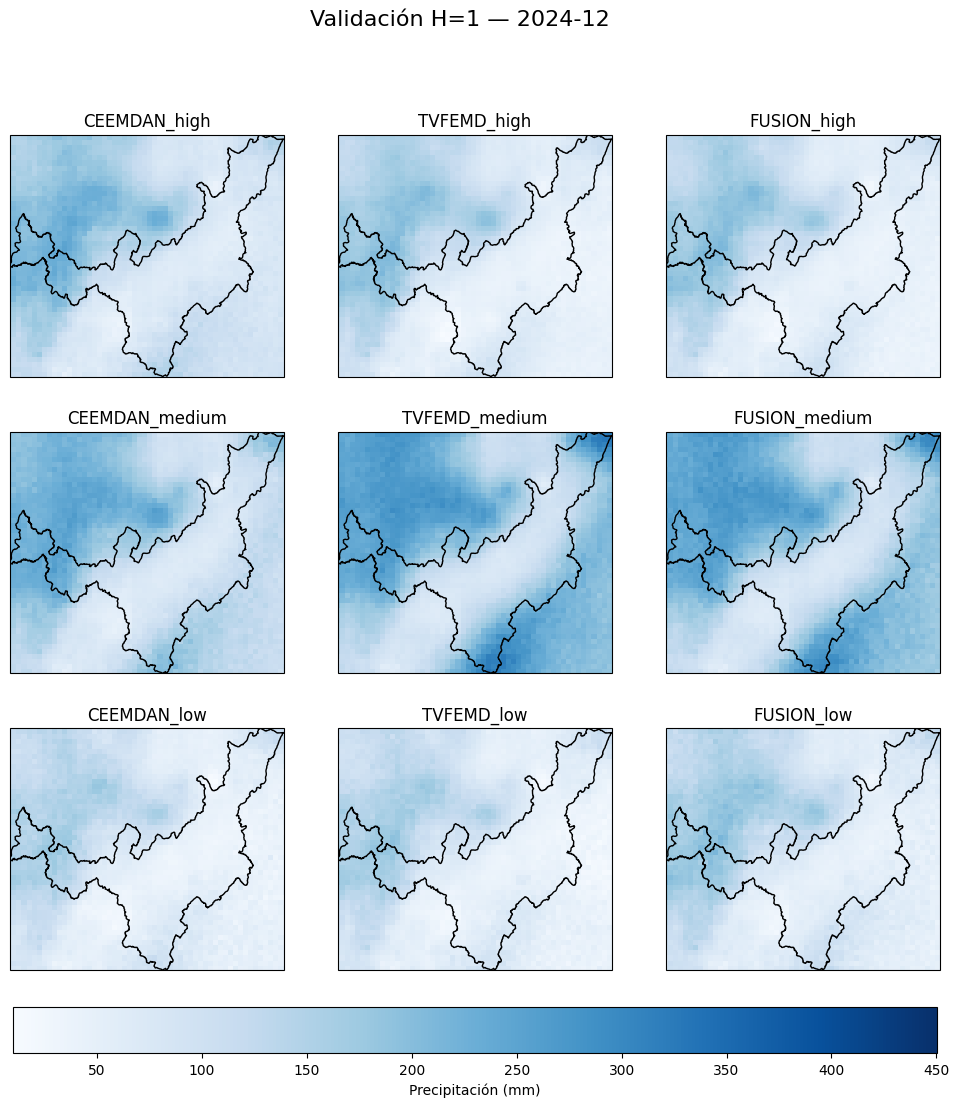

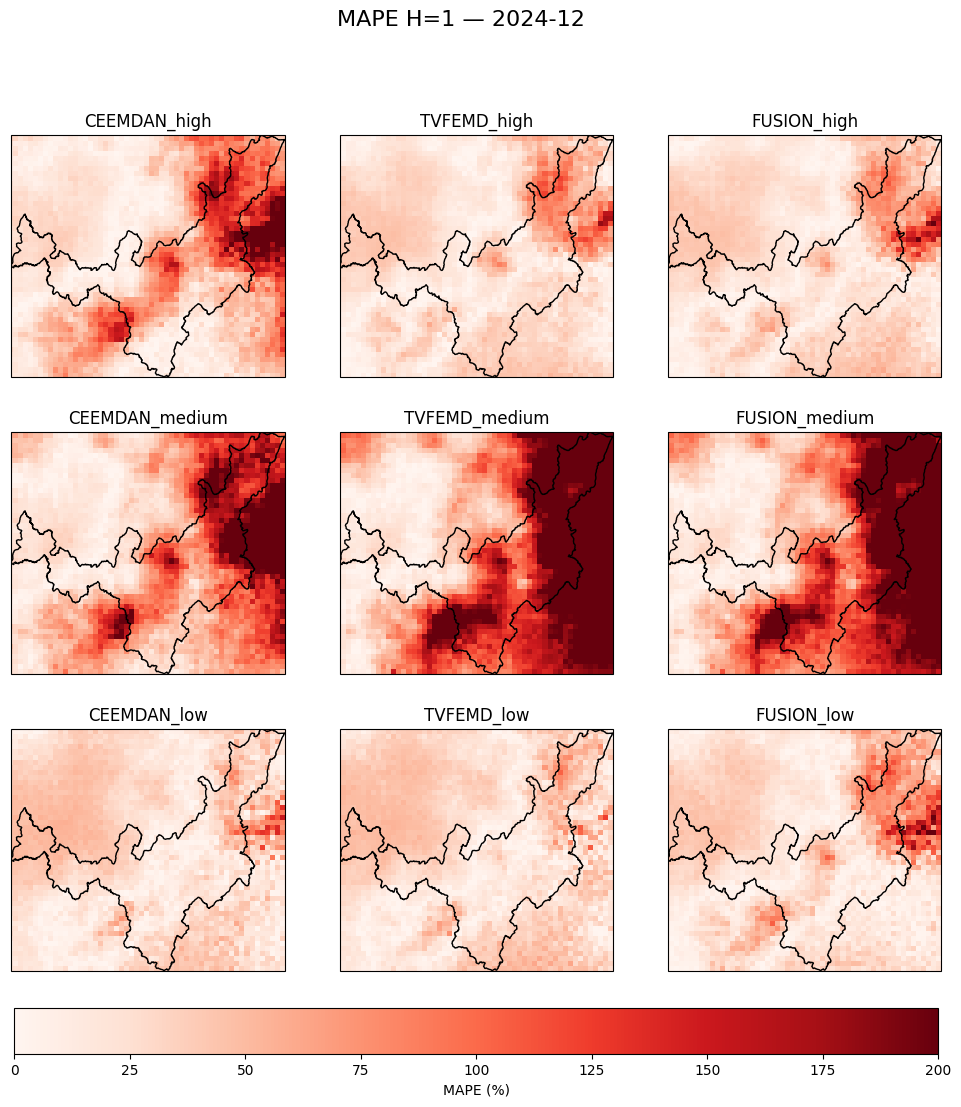

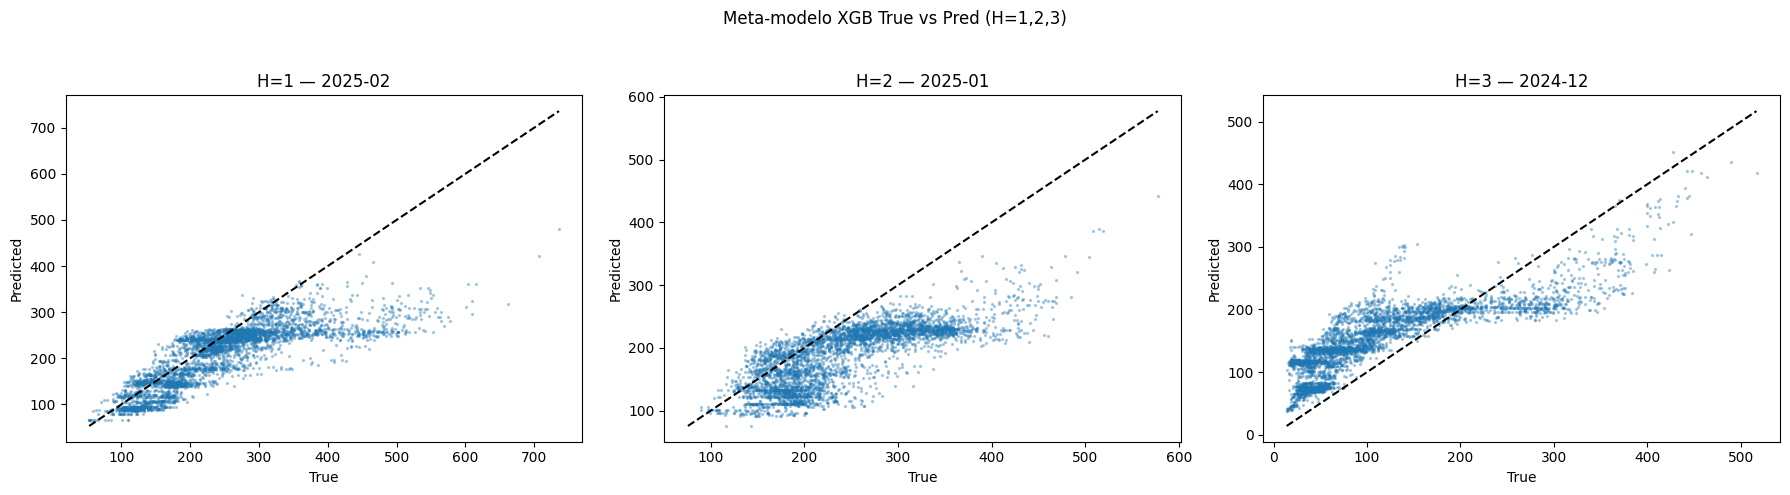

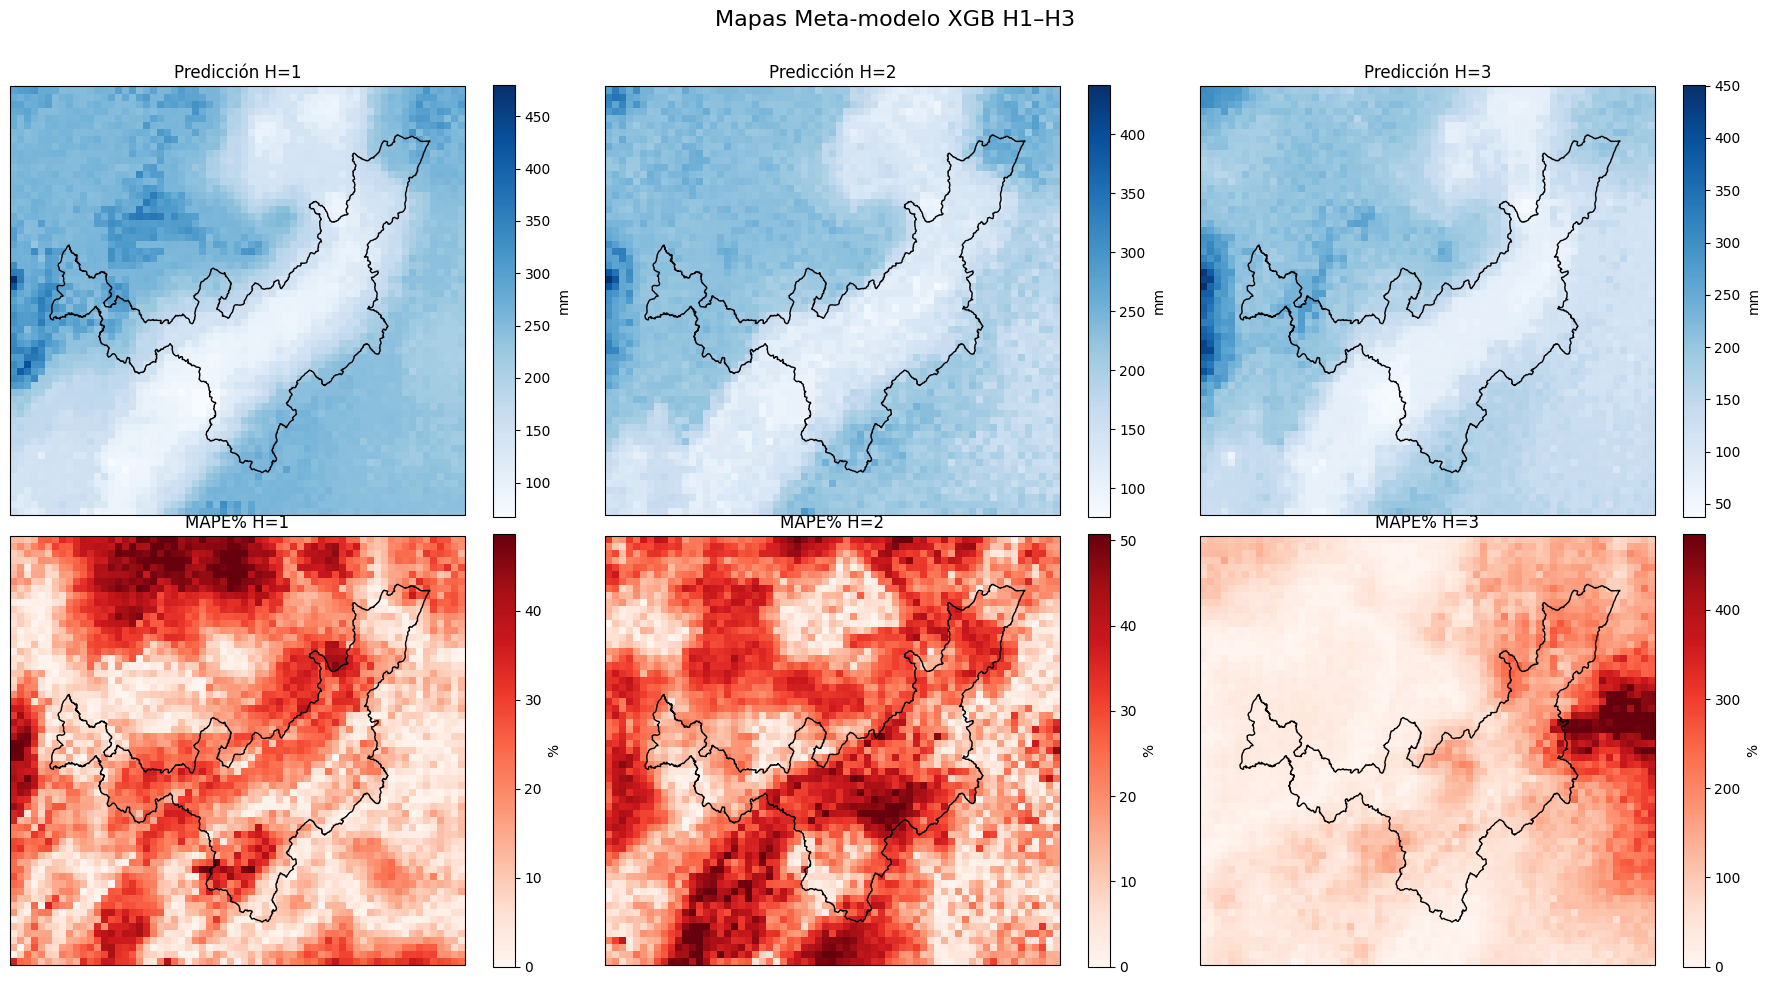

Meta-metrics H1-3 ref2025-02


Loading ITables v2.4.0 from the internet... (need help?)


In [1]:
# -*- coding: utf-8 -*-
"""
Entrenamiento Multi‐rama con GRU encoder–decoder y Transformer para low,
validación y forecast parametrizables, meta‐modelo XGBoost (stacking all H=1–3),
paralelización, trazabilidad y límites del departamento de Boyacá.
"""

import sys
from pathlib import Path
import warnings
import logging

# 0) Detectar entorno (Local / Colab)
IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    from google.colab import drive
    drive.mount("/content/drive", force_remount=True)
    BASE_PATH = Path("/content/drive/MyDrive/ml_precipitation_prediction")
    !pip install -q xarray netCDF4 optuna seaborn cartopy xgboost ace_tools_open cartopy
else:
    BASE_PATH = Path.cwd()
    for p in [BASE_PATH, *BASE_PATH.parents]:
        if (p/".git").exists():
            BASE_PATH = p
            break
print(f"▶️ Base path: {BASE_PATH}")

# 1) Suprimir warnings irrelevantes
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
from cartopy.io import DownloadWarning
warnings.filterwarnings("ignore", category=DownloadWarning)
import tensorflow as tf
tf.get_logger().setLevel("ERROR")

# 2) Parámetros configurables
INPUT_WINDOW    = 60          # meses de entrada
OUTPUT_HORIZON  = 3           # meses de validación y forecast
REF_DATE        = "2025-03"   # fecha de referencia yyyy-mm
MAX_EPOCHS      = 300
PATIENCE_ES     = 30
LR_FACTOR       = 0.5
LR_PATIENCE     = 10
DROPOUT         = 0.1

# 3) Rutas y logger
MODEL_DIR    = BASE_PATH/"models"/"output"/"trained_models"
MODEL_DIR.mkdir(parents=True, exist_ok=True)
FEATURES_NC  = BASE_PATH/"models"/"output"/"features_fusion_branches.nc"
FULL_NC      = BASE_PATH/"data"/"output"/"complete_dataset_with_features_with_clusters_elevation_with_windows.nc"
SHP_USER     = Path("/mnt/data/MGN_Departamento.shp")
BOYACA_SHP   = SHP_USER if SHP_USER.exists() else BASE_PATH/"data"/"input"/"shapes"/"MGN_Departamento.shp"
RESULTS_CSV  = MODEL_DIR/f"metrics_w{OUTPUT_HORIZON}_ref{REF_DATE}.csv"
IMAGE_DIR    = MODEL_DIR/"images"
IMAGE_DIR.mkdir(parents=True, exist_ok=True)

logging.basicConfig(level=logging.INFO, format="%(asctime)s %(levelname)s %(message)s")
logger = logging.getLogger(__name__)

# 4) Imports principales
import numpy            as np
import pandas           as pd
import xarray           as xr
import geopandas        as gpd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import psutil
from joblib import cpu_count
from tensorflow.keras.layers import (
    Input, GRU, RepeatVector, TimeDistributed, Dense,
    MultiHeadAttention, Add, LayerNormalization, Flatten
)
from tensorflow.keras.models import Model
from tensorflow.keras import callbacks

# 5) Recursos hardware
CORES     = cpu_count()
AVAIL_RAM = psutil.virtual_memory().available / (1024**3)
gpus      = tf.config.list_physical_devices("GPU")
USE_GPU   = bool(gpus)
if USE_GPU:
    tf.config.experimental.set_memory_growth(gpus[0], True)
    logger.info(f"🖥 GPU disponible: {gpus[0].name}")
else:
    tf.config.threading.set_inter_op_parallelism_threads(CORES)
    tf.config.threading.set_intra_op_parallelism_threads(CORES)
    logger.info(f"⚙ CPU cores: {CORES}, RAM libre: {AVAIL_RAM:.1f} GB")

# 6) Modelos y utilitarios
def evaluate_metrics(y_true, y_pred):
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    mae  = np.mean(np.abs(y_true - y_pred))
    mape = np.mean(np.abs((y_true - y_pred)/(y_true + 1e-5))) * 100
    r2   = 1 - np.sum((y_true - y_pred)**2) / np.sum((y_true - np.mean(y_true))**2)
    return rmse, mae, mape, r2

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, X, Y, batch_size=32, **kwargs):
        super().__init__(**kwargs)
        self.X, self.Y = X.astype(np.float32), Y.astype(np.float32)
        self.batch_size = batch_size
    def __len__(self):
        return int(np.ceil(len(self.X) / self.batch_size))
    def __getitem__(self, idx):
        sl = slice(idx*self.batch_size, (idx+1)*self.batch_size)
        return self.X[sl], self.Y[sl]

# GRU-ED y Transformer-ED builders
from tensorflow.keras import backend as K

def build_gru_ed(input_shape, horizon, n_cells, latent=128, dropout=DROPOUT):
    inp = Input(shape=input_shape)
    x = GRU(latent, dropout=dropout)(inp)
    x = RepeatVector(horizon)(x)
    x = GRU(latent, dropout=dropout, return_sequences=True)(x)
    out = TimeDistributed(Dense(n_cells))(x)
    m = Model(inp, out)
    m.compile(optimizer="adam", loss="mse")
    return m


def build_transformer_ed(input_shape, horizon, n_cells,
                         head_size=64, num_heads=4, ff_dim=256, dropout=0.1):
    inp = Input(shape=input_shape)
    attn = MultiHeadAttention(num_heads=num_heads, key_dim=head_size)(inp, inp)
    x = Add()([inp, attn])
    x = LayerNormalization(epsilon=1e-6)(x)
    ff = Dense(ff_dim, activation="relu")(x)
    ff = Dense(input_shape[-1])(ff)
    x = Add()([x, ff])
    x = LayerNormalization(epsilon=1e-6)(x)
    x = Flatten()(x)
    x = Dense(horizon * n_cells)(x)
    out = K.reshape(x, (-1, horizon, n_cells))
    m = Model(inp, out)
    m.compile(optimizer="adam", loss="mse")
    return m


def build_gru_ed_low(input_shape, horizon, n_cells,
                     latent=256, dropout=0.1, use_transformer=True):
    if use_transformer:
        try:
            return build_transformer_ed(input_shape, horizon, n_cells,
                                        head_size=64, num_heads=4,
                                        ff_dim=512, dropout=dropout)
        except tf.errors.ResourceExhaustedError:
            logger.warning("OOM Transformer → usando GRU‐ED para low-branch")
    return build_gru_ed(input_shape, horizon, n_cells,
                        latent=latent, dropout=dropout)


def build_gru_ed_medium_high(input_shape, horizon, n_cells, latent=128, dropout=0.1, use_transformer=True):
    try:
        if use_transformer:
            return build_transformer_ed(input_shape, horizon, n_cells,
                                        head_size=64, num_heads=4,
                                        ff_dim=512, dropout=dropout)
        else:
            return build_gru_ed(input_shape, horizon, n_cells,
                                latent=latent, dropout=dropout)
    except tf.errors.ResourceExhaustedError:
        logger.warning("OOM Transformer → usando GRU‐ED para medium/high")
        return build_gru_ed(input_shape, horizon, n_cells,
                            latent=latent, dropout=dropout)

# 7) Carga datos y shapefile
logger.info("📂 Cargando datasets…")
ds_full = xr.open_dataset(FULL_NC)
ds_feat = xr.open_dataset(FEATURES_NC)
boyaca_gdf = gpd.read_file(BOYACA_SHP)
if boyaca_gdf.crs is None:
    boyaca_gdf.set_crs(epsg=4326, inplace=True)
else:
    boyaca_gdf = boyaca_gdf.to_crs(epsg=4326)

times      = ds_full.time.values.astype("datetime64[M]")
user_ref   = np.datetime64(REF_DATE, "M")
last_avail = times[-1]
ref = last_avail if user_ref>last_avail else user_ref

val_dates = [
    str(ref),
    str((ref - np.timedelta64(1,'M')).astype("datetime64[M]")),
    str((ref - np.timedelta64(2,'M')).astype("datetime64[M]"))
]
fc_dates  = [str((ref + np.timedelta64(i+1,'M')).astype("datetime64[M]")) for i in range(OUTPUT_HORIZON)]

idx_ref = int(np.where(times == ref)[0][0])
lat     = ds_full.latitude.values
lon     = ds_full.longitude.values
METHODS = ["CEEMDAN","TVFEMD","FUSION"]
BRANCHES= ["high","medium","low"]

all_metrics = []
preds_store = {}
true_store  = {}
histories   = {}

# callbacks
es_cb = callbacks.EarlyStopping("val_loss", patience=PATIENCE_ES, restore_best_weights=True)
lr_cb = callbacks.ReduceLROnPlateau("val_loss", factor=LR_FACTOR, patience=LR_PATIENCE, min_lr=1e-6)

# 8) Bucle principal
for method in METHODS:
    for branch in BRANCHES:
        name = f"{method}_{branch}"
        if name not in ds_feat.data_vars:
            logger.warning(f"⚠ {name} no existe, salto.")
            continue
        logger.info(f"▶ Procesando {name}")
        try:
            # extraer y aplanar
            Xarr = ds_feat[name].values            # (T, ny, nx)
            Yarr = ds_full["total_precipitation"].values  # (T, ny, nx)
            T, ny, nx = Xarr.shape
            n_cells   = ny * nx

            Xfull = Xarr.reshape(T, n_cells)
            yfull = Yarr.reshape(T, n_cells)

            # ventanas
            Nw = T - INPUT_WINDOW - OUTPUT_HORIZON + 1
            if Nw <= 0:
                logger.warning("❌ Ventanas insuficientes.")
                continue

            Xs = np.stack([Xfull[i : i+INPUT_WINDOW] for i in range(Nw)], axis=0)
            ys = np.stack([yfull[i+INPUT_WINDOW : i+INPUT_WINDOW+OUTPUT_HORIZON]
                           for i in range(Nw)], axis=0)

            # sin/cos para low
            if branch == "low":
                months = pd.to_datetime(ds_full.time.values).month.values
                s = np.sin(2 * np.pi * months/12)
                c = np.cos(2 * np.pi * months/12)
                Ss = np.stack([s[i : i+INPUT_WINDOW] for i in range(Nw)], axis=0)
                Cs = np.stack([c[i : i+INPUT_WINDOW] for i in range(Nw)], axis=0)
                Ss = np.repeat(Ss[:,:,None], n_cells, axis=2)
                Cs = np.repeat(Cs[:,:,None], n_cells, axis=2)
                Xs = np.concatenate([Xs, Ss, Cs], axis=2)
                n_feats = Xs.shape[2]
            else:
                n_feats = n_cells

            # escalado
            scX = StandardScaler().fit(Xs.reshape(-1, n_feats))
            scY = StandardScaler().fit(ys.reshape(-1, n_cells))
            Xs_s = scX.transform(Xs.reshape(-1, n_feats)).reshape(Xs.shape)
            ys_s = scY.transform(ys.reshape(-1, n_cells)).reshape(ys.shape)

            # partición centrada en REF_DATE
            k_ref = np.clip(idx_ref - INPUT_WINDOW + 1, 0, Nw-1)
            i0    = np.clip(k_ref - (OUTPUT_HORIZON-1), 0, Nw-OUTPUT_HORIZON)

            X_tr, y_tr = Xs_s[:i0], ys_s[:i0]
            X_va, y_va = Xs_s[i0 : i0+OUTPUT_HORIZON], ys_s[i0 : i0+OUTPUT_HORIZON]

            # cargar/entrenar
            model_path = MODEL_DIR/f"{name}_w{OUTPUT_HORIZON}_ref{ref}.keras"
            if model_path.exists():
                model = tf.keras.models.load_model(str(model_path), compile=False)
                model.compile(optimizer="adam", loss="mse")
                logger.info(f"⏩ Cargado modelo: {model_path.name}")
            else:
                if branch == "low":
                    model = build_gru_ed_low((INPUT_WINDOW, n_feats), OUTPUT_HORIZON, n_cells)
                else:
                    model = build_gru_ed_medium_high((INPUT_WINDOW, n_feats), OUTPUT_HORIZON, n_cells)

                hist = model.fit(
                    DataGenerator(X_tr, y_tr),
                    validation_data=DataGenerator(X_va, y_va),
                    epochs=MAX_EPOCHS,
                    callbacks=[es_cb, lr_cb],
                    verbose=1
                )
                model.save(str(model_path))
                histories[name] = hist.history

            # validación H=1..H
            preds = model.predict(X_va, verbose=0).reshape(OUTPUT_HORIZON, OUTPUT_HORIZON, n_cells)
            for h in range(OUTPUT_HORIZON):
                date_val = val_dates[h]
                pm_flat  = preds[h,0]
                tm_flat  = y_va[h,0]
                pm = scY.inverse_transform(pm_flat.reshape(1,-1))[0].reshape(ny,nx)
                tm = scY.inverse_transform(tm_flat.reshape(1,-1))[0].reshape(ny,nx)
                rmse, mae, mape, r2 = evaluate_metrics(tm.ravel(), pm.ravel())
                all_metrics.append({
                    "model": name, "branch": branch, "horizon": h+1,
                    "type":"validation", "date": date_val,
                    "RMSE": rmse, "MAE": mae, "MAPE": mape, "R2": r2
                })
                preds_store[(name,date_val)] = pm
                true_store[(name,date_val)]  = tm

            # forecast
            X_fc = Xs_s[k_ref : k_ref+1]
            fc_s = model.predict(X_fc, verbose=0)[0]
            FC   = scY.inverse_transform(fc_s)
            for h in range(OUTPUT_HORIZON):
                date_fc = fc_dates[h]
                all_metrics.append({
                    "model": name, "branch": branch, "horizon": h+1,
                    "type":"forecast", "date": date_fc,
                    "RMSE": np.nan, "MAE": np.nan, "MAPE": np.nan, "R2": np.nan
                })
                preds_store[(name,date_fc)] = FC[h].reshape(ny,nx)

        except Exception:
            logger.exception(f"‼ Error en {name}, continuo…")
            continue

# 9) Guardar métricas y mostrar tabla
dfm = pd.DataFrame(all_metrics)
dfm.to_csv(RESULTS_CSV, index=False)
import ace_tools_open as tools
import cartopy.crs as ccrs
tools.display_dataframe_to_user(name=f"Metrics_w{OUTPUT_HORIZON}_ref{ref}", dataframe=dfm)

# 10) Curvas de entrenamiento
for name, hist in histories.items():
    plt.figure(figsize=(6,4))
    plt.plot(hist["loss"],  label="train")
    plt.plot(hist["val_loss"],label="val")
    plt.title(f"Loss curve: {name}")
    plt.xlabel("Epoch"); plt.ylabel("MSE")
    plt.legend(); plt.tight_layout(); plt.show()

# 10bis) True vs Predicted por rama y horizonte
for branch in BRANCHES:
    for h in range(1, OUTPUT_HORIZON+1):
        plt.figure(figsize=(5,5))
        for method in METHODS:
            key = f"{method}_{branch}"
            date_val = val_dates[h-1]
            if (key, date_val) in preds_store and (key, date_val) in true_store:
                y_true = true_store[(key, date_val)].ravel()
                y_pred = preds_store[(key, date_val)].ravel()
                plt.scatter(y_true, y_pred, alpha=0.3, s=2, label=method)
        lims = [0, max(plt.xlim()[1], plt.ylim()[1])]
        plt.plot(lims, lims, 'k--')
        plt.xlabel("True"); plt.ylabel("Predicted")
        plt.title(f"True vs Pred — {branch}, H={h}")
        plt.legend(); plt.tight_layout(); plt.show()

# 11) Mapas 3×3 validación H=1
xmin, ymin, xmax, ymax = boyaca_gdf.total_bounds
for date_val in val_dates:
    arrs = [preds_store[(f"{m}_{b}",date_val)].ravel()
            for m in METHODS for b in BRANCHES
            if (f"{m}_{b}",date_val) in preds_store]
    if not arrs:
        logger.warning(f"No hay predicciones para {date_val}, salto plot.")
        continue
    vmin, vmax = np.min(arrs), np.max(arrs)
    fig, axs = plt.subplots(3,3, figsize=(12,12), subplot_kw={"projection":ccrs.PlateCarree()})
    fig.suptitle(f"Validación H=1 — {date_val}", fontsize=16)
    for i, b in enumerate(BRANCHES):
        for j, m in enumerate(METHODS):
            ax = axs[i,j]
            ax.set_extent([xmin, xmax, ymin, ymax], ccrs.PlateCarree())
            ax.add_geometries(boyaca_gdf.geometry, ccrs.PlateCarree(),
                              edgecolor="black", facecolor="none", linewidth=1)
            key = (f"{m}_{b}", date_val)
            if key in preds_store:
                pcm = ax.pcolormesh(lon, lat, preds_store[key],
                                    vmin=vmin, vmax=vmax,
                                    transform=ccrs.PlateCarree(), cmap="Blues")
            ax.set_title(f"{m}_{b}")
    fig.colorbar(pcm, ax=axs, orientation="horizontal",
                 fraction=0.05, pad=0.04, label="Precipitación (mm)")
    fig.savefig(IMAGE_DIR/f"val_H1_{date_val}.png", dpi=150); plt.show()

    arrs_mape = [
        np.clip(np.abs((true_store[k] - preds_store[k])/(true_store[k]+1e-5))*100,0,200).ravel()
        for k in preds_store if k[1]==date_val and k in true_store
    ]
    if not arrs_mape: continue
    vmin2, vmax2 = 0, np.max(arrs_mape)
    fig, axs = plt.subplots(3,3, figsize=(12,12), subplot_kw={"projection":ccrs.PlateCarree()})
    fig.suptitle(f"MAPE H=1 — {date_val}", fontsize=16)
    for i, b in enumerate(BRANCHES):
        for j, m in enumerate(METHODS):
            ax = axs[i,j]
            ax.set_extent([xmin, xmax, ymin, ymax], ccrs.PlateCarree())
            ax.add_geometries(boyaca_gdf.geometry, ccrs.PlateCarree(),
                              edgecolor="black", facecolor="none", linewidth=1)
            key = (f"{m}_{b}", date_val)
            if key in preds_store and key in true_store:
                mmap = np.clip(np.abs((true_store[key] - preds_store[key])/(true_store[key]+1e-5))*100,0,200)
                pcm2 = ax.pcolormesh(lon, lat, mmap,
                                     vmin=vmin2, vmax=vmax2,
                                     transform=ccrs.PlateCarree(), cmap="Reds")
            ax.set_title(f"{m}_{b}")
    fig.colorbar(pcm2, ax=axs, orientation="horizontal",
                 fraction=0.05, pad=0.04, label="MAPE (%)")
    fig.savefig(IMAGE_DIR/f"mape_H1_{date_val}.png", dpi=150); plt.show()

# 13) META‐MODELOS XGB stacking H=1-3
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# --- Helper para ajustar la forma de X antes de predecir con XGBoost ---
def xgb_predict_adjusted(model, X):
    """
    Asegura que X tenga el mismo número de columnas (features)
    que el modelo XGB espera. Si no coincide, truncamos.
    """
    # Access the underlying Booster object to get the number of features
    expected = model._Booster.num_features()
    if X.shape[1] != expected:
        logger.warning(
            f"Feature shape mismatch: modelo espera {expected}, "
            f"got {X.shape[1]}. Truncando a las primeras {expected} columnas."
        )
        X = X[:, :expected]
    return model.predict(X)

meta_metrics_all = []

# 13.1) Scatter subplot H=1,2,3
fig_sc, axs_sc = plt.subplots(1,3, figsize=(18,5))
for idx_h, h in enumerate(range(1, OUTPUT_HORIZON+1)):
    date = val_dates[h-1]
    mdl = MODEL_DIR/f"xgb_all_H{h}_{ref}.json"
    if mdl.exists():
        keys = [(f"{m}_{b}", date) for m in METHODS for b in BRANCHES]
        feats = np.stack([preds_store[k].ravel() for k in keys], axis=1)
        xgb = XGBRegressor(); xgb.load_model(str(mdl))
        ypred = xgb_predict_adjusted(xgb, feats)
        ytrue = true_store[(f"{METHODS[0]}_low", date)].ravel()
        ax = axs_sc[idx_h]
        ax.scatter(ytrue, ypred, alpha=0.3, s=2)
        lims = [min(ytrue.min(), ypred.min()), max(ytrue.max(), ypred.max())]
        ax.plot(lims, lims, 'k--')
        ax.set_title(f"H={h} — {date}")
        ax.set_xlabel("True"); ax.set_ylabel("Predicted")
    else:
        axs_sc[idx_h].text(0.5,0.5,f"No model H={h}",ha='center',va='center')
fig_sc.suptitle("Meta‐modelo XGB True vs Pred (H=1,2,3)")
fig_sc.tight_layout(rect=[0,0,1,0.95])
fig_sc.savefig(IMAGE_DIR/f"meta_scatter_H1-3_{ref}.png", dpi=150)
plt.show()

# 13.2) Mapas Pred y MAPE en 2×3
try:
    import cartopy.crs as ccrs
    has_cartopy = True
except ImportError:
    has_cartopy = False

if has_cartopy:
    fig_mp, axs_mp = plt.subplots(2,3, figsize=(18,10), subplot_kw={"projection":ccrs.PlateCarree()})
    for j,h in enumerate(range(1, OUTPUT_HORIZON+1)):
        date = val_dates[h-1]
        mdl  = MODEL_DIR/f"xgb_all_H{h}_{ref}.json"
        if mdl.exists():
            keys = [(f"{m}_{b}", date) for m in METHODS for b in BRANCHES]
            feats = np.stack([preds_store[k].ravel() for k in keys], axis=1)
            xgb = XGBRegressor(); xgb.load_model(str(mdl))
            P = xgb_predict_adjusted(xgb, feats)
            T = true_store[(f"{METHODS[0]}_low", date)]
            # Flatten T to match the shape of P for element-wise operations
            T_flat = T.ravel()
            # Calculate MAPE using the flattened true and predicted values
            M_flat = np.abs((T_flat - P)/(T_flat + 1e-5))*100
            # Reshape M_flat back to the original grid shape for plotting
            # M = M_flat.reshape(lat.shape) # Original line causing the error
            M = M_flat.reshape(ny, nx)
            # Reshape to the 2D grid shape (ny, nx)
            ax0 = axs_mp[0,j]
            # Reshape P to (ny, nx) for pcolormesh
            pcm = ax0.pcolormesh(lon, lat, P.reshape(ny, nx), transform=ccrs.PlateCarree(), cmap="Blues")
            boyaca_gdf.boundary.plot(ax=ax0, edgecolor='black', linewidth=1, transform=ccrs.PlateCarree())
            ax0.set_title(f"Predicción H={h}")
            fig_mp.colorbar(pcm, ax=ax0, orientation='vertical', label='mm')
            ax1 = axs_mp[1,j]
            pcm2 = ax1.pcolormesh(lon, lat, M, transform=ccrs.PlateCarree(), cmap="Reds", vmin=0, vmax=np.nanpercentile(M,99))
            boyaca_gdf.boundary.plot(ax=ax1, edgecolor='black', linewidth=1, transform=ccrs.PlateCarree())
            ax1.set_title(f"MAPE% H={h}")
            fig_mp.colorbar(pcm2, ax=ax1, orientation='vertical', label='%')
        else:
            for row in (0,1): axs_mp[row,j].text(0.5,0.5,f"No model H={h}", ha='center', va='center')
    fig_mp.suptitle("Mapas Meta‐modelo XGB H1–H3", fontsize=16)
    fig_mp.tight_layout(rect=[0,0,1,0.96])
    fig_mp.savefig(IMAGE_DIR/f"meta_maps_H1-3_{ref}.png", dpi=150)
    plt.show()

# 13.3) Tabla final de métricas meta-modelo
for h in range(1, OUTPUT_HORIZON+1):
    date = val_dates[h-1]
    mdl  = MODEL_DIR/f"xgb_all_H{h}_{ref}.json"
    if mdl.exists():
        keys = [(f"{m}_{b}", date) for m in METHODS for b in BRANCHES]
        feats = np.stack([preds_store[k].ravel() for k in keys], axis=1)
        xgb   = XGBRegressor(); xgb.load_model(str(mdl))
        ypred = xgb_predict_adjusted(xgb, feats)
        ytrue = true_store[(f"{METHODS[0]}_low", date)].ravel()
        rm, ma, maP, r_ = evaluate_metrics(ytrue, ypred)
        meta_metrics_all.append({
            'horizon': h,
            'date':    date,
            'RMSE':    rm,
            'MAE':     ma,
            'MAPE':    maP,
            'R2':      r_
        })

# Exportar y mostrar tabla
import ace_tools_open as tools
df_meta_all = pd.DataFrame(meta_metrics_all)
meta_csv = MODEL_DIR/f"meta_metrics_maps_H1-3_ref{ref}.csv"
df_meta_all.to_csv(meta_csv, index=False)
tools.display_dataframe_to_user(name=f"Meta-metrics H1-3 ref{ref}", dataframe=df_meta_all)

logger.info("🏁 Proceso completo.")